In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

## Importanción de datos

In [3]:
mes_datos="2022-1"

In [11]:
! wget https://transparenciachc.blob.core.windows.net/oc-da/{mes_datos}.zip

--2022-05-28 23:01:36--  https://transparenciachc.blob.core.windows.net/oc-da/2022-1.zip
Resolving transparenciachc.blob.core.windows.net (transparenciachc.blob.core.windows.net)... 52.226.8.148
Connecting to transparenciachc.blob.core.windows.net (transparenciachc.blob.core.windows.net)|52.226.8.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59080491 (56M) [application/zip]
Saving to: ‘2022-1.zip’

2022-1.zip          100%[===================>]  56.34M  2.33MB/s    in 17s     

2022-05-28 23:01:54 (3.32 MB/s) - ‘2022-1.zip’ saved [59080491/59080491]



In [12]:
! ls

2022-1.zip  Obligatorio_Francisco_Rossi_Ivan_Monjardin.ipynb


In [18]:
! unzip -o {mes_datos}.zip 

Archive:  2022-1.zip
  inflating: 2022-1.csv              


In [19]:
! ls

2022-1.csv  2022-1.zip	Obligatorio_Francisco_Rossi_Ivan_Monjardin.ipynb


In [20]:
 rm  {mes_datos}.zip  

In [21]:
! ls

2022-1.csv  Obligatorio_Francisco_Rossi_Ivan_Monjardin.ipynb


## Limpieza archivo CVS

Algunos valores incluyen "Enters" adentro de los valores, por lo tanto vamos a eliminarlos para que se lea bien el csv

In [22]:
def valid_csv_line (line, quote_char, col_quanity):
    num_of_col = 1
    is_inside_quotes = False
    for char in line:
        if char == quote_char:
            is_inside_quotes = not is_inside_quotes
        else:
            if char == ";" and (not is_inside_quotes):
                num_of_col = num_of_col + 1
                if num_of_col > col_quanity:
                    return False
                
    return num_of_col == col_quanity
            

In [13]:
# def valid_csv_line (line, quote_char, col_quantity):
#     return line.count(';') >= (col_quantity -1 )

Arregla filas incorrectas con "enters" por la mitad

In [23]:
archivoInicial = open(f'{mes_datos}.csv', 'r', encoding='ISO-8859-1')
import os

if os.path.exists(f'{mes_datos}-corregido.csv'):
  os.remove(f'{mes_datos}-corregido.csv')

archivoFinal = open(f'{mes_datos}-corregido.csv', 'a+', encoding='ISO-8859-1' )
Lines = archivoInicial.readlines()

correct_new_line = ""
for line in Lines:
    correct_new_line = correct_new_line + line.rstrip()
    
    if valid_csv_line(correct_new_line,"\"",78):
        archivoFinal.writelines(correct_new_line + '\n')

        correct_new_line = ""

In [26]:
archivoInicial.close()
archivoFinal.close()

In [27]:
df_original_corregido = spark.read.format("csv").options(header=True, delimiter=';',encoding="ISO-8859-1").csv('2022-1-corregido.csv')

In [28]:
df_original_corregido.show(10,vertical=True)

-RECORD 0------------------------------------------
 ID                         | 41200292             
 Codigo                     | 653-4-SE20           
 Link                       | http://www.mercad... 
 Nombre                     | FTO DON CARLOS, C... 
 Descripcion/Obervaciones   | SERVICIOS DE F.T.... 
 Tipo                       | SE                   
 ProcedenciaOC              | Proveniente de li... 
 EsTratoDirecto             | No                   
 EsCompraAgil               | No                   
 CodigoTipo                 | 8                    
 CodigoAbreviadoTipoOC      | SE                   
 DescripcionTipoOC          | Sin emisión autom... 
 codigoEstado               | 6                    
 Estado                     | Aceptada             
 codigoEstadoProveedor      | 4                    
 EstadoProveedor            | Aceptada             
 FechaCreacion              | 2020-01-08           
 FechaEnvio                 | 2022-01-04           
 FechaSolici

## Ingeniería de Atributos

### Columnas Relevantes
Eliminamos las columnas que no sean relevanes para nuestro analisis, dejando solo las que sí podemos llegar a utilizar 

In [29]:
df_original = df_original_corregido

In [31]:
df_original.columns

['ID',
 'Codigo',
 'Link',
 'Nombre',
 'Descripcion/Obervaciones',
 'Tipo',
 'ProcedenciaOC',
 'EsTratoDirecto',
 'EsCompraAgil',
 'CodigoTipo',
 'CodigoAbreviadoTipoOC',
 'DescripcionTipoOC',
 'codigoEstado',
 'Estado',
 'codigoEstadoProveedor',
 'EstadoProveedor',
 'FechaCreacion',
 'FechaEnvio',
 'FechaSolicitudCancelacion',
 'fechaUltimaModificacion',
 'FechaAceptacion',
 'FechaCancelacion',
 'tieneItems',
 'PromedioCalificacion',
 'CantidadEvaluacion',
 'MontoTotalOC',
 'TipoMonedaOC',
 'MontoTotalOC_PesosChilenos',
 'Impuestos',
 'TipoImpuesto',
 'Descuentos',
 'Cargos',
 'TotalNetoOC',
 'CodigoUnidadCompra',
 'RutUnidadCompra',
 'UnidadCompra',
 'CodigoOrganismoPublico',
 'OrganismoPublico',
 'sector',
 'ActividadComprador',
 'CiudadUnidadCompra',
 'RegionUnidadCompra',
 'PaisUnidadCompra',
 'CodigoSucursal',
 'RutSucursal',
 'Sucursal',
 'CodigoProveedor',
 'NombreProveedor',
 'ActividadProveedor',
 'ComunaProveedor',
 'RegionProveedor',
 'PaisProveedor',
 'Financiamiento',
 'P

In [32]:
df_columnas_relevantes = df_original[
    ['Estado',
 'FechaCreacion',
 'FechaAceptacion',
 'MontoTotalOC_PesosChilenos',
 'OrganismoPublico',
 'sector',
 'CiudadUnidadCompra',
 'RegionUnidadCompra',
 'PaisProveedor',
 'IDItem',
 'RubroN1',
 'RubroN2',
 'RubroN3',
 'cantidad',
 'UnidadMedida']
]

In [33]:
df_columnas_relevantes.show(15,vertical=True)

-RECORD 0------------------------------------------
 Estado                     | Aceptada             
 FechaCreacion              | 2020-01-08           
 FechaAceptacion            | 2022-01-05           
 MontoTotalOC_PesosChilenos | 55699353,7632        
 OrganismoPublico           | SERVICIO DE VIVIE... 
 sector                     | Obras Públicas       
 CiudadUnidadCompra         | Talca                
 RegionUnidadCompra         | Región del Maule     
 PaisProveedor              | null                 
 IDItem                     | 108832323            
 RubroN1                    | Servicios profesi... 
 RubroN2                    | Consultorías o as... 
 RubroN3                    | Gestión de proyectos 
 cantidad                   | 1                    
 UnidadMedida               | Global               
-RECORD 1------------------------------------------
 Estado                     | Aceptada             
 FechaCreacion              | 2020-01-20           
 FechaAcepta

In [34]:
df_columnas_relevantes.count()

281675

#### Eliminar filas que no cuentas con un Estado válido. Deberían ser solo 5 posibles valores

In [35]:
df_columnas_relevantes.select("Estado").distinct().show(vertical=True)

-RECORD 0----------------------
 Estado | Compra Ágil          
-RECORD 1----------------------
 Estado | Sin emisión autom... 
-RECORD 2----------------------
 Estado | Convenio Marco       
-RECORD 3----------------------
 Estado | 8                    
-RECORD 4----------------------
 Estado | 6                    
-RECORD 5----------------------
 Estado | CM                   
-RECORD 6----------------------
 Estado | Cancelacion solic... 
-RECORD 7----------------------
 Estado | En proceso           
-RECORD 8----------------------
 Estado | Recepcion Conforme   
-RECORD 9----------------------
 Estado | Enviada a proveedor  
-RECORD 10---------------------
 Estado | 12                   
-RECORD 11---------------------
 Estado | Aceptada             



In [36]:
estados_validos = ["Aceptada", "En proceso","Cancelacion solicitada", "Enviada a proveedor", "Recepcion Conforme"] 

In [37]:
df_estados_validos =df_columnas_relevantes.filter(df_columnas_relevantes.Estado.isin(estados_validos))
df_estados_validos.select("Estado").distinct().show(vertical=True)

-RECORD 0----------------------
 Estado | Cancelacion solic... 
-RECORD 1----------------------
 Estado | En proceso           
-RECORD 2----------------------
 Estado | Recepcion Conforme   
-RECORD 3----------------------
 Estado | Enviada a proveedor  
-RECORD 4----------------------
 Estado | Aceptada             



### Analisis de atributos


In [38]:
df = df_estados_validos

In [39]:
df.printSchema()

root
 |-- Estado: string (nullable = true)
 |-- FechaCreacion: string (nullable = true)
 |-- FechaAceptacion: string (nullable = true)
 |-- MontoTotalOC_PesosChilenos: string (nullable = true)
 |-- OrganismoPublico: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- CiudadUnidadCompra: string (nullable = true)
 |-- RegionUnidadCompra: string (nullable = true)
 |-- PaisProveedor: string (nullable = true)
 |-- IDItem: string (nullable = true)
 |-- RubroN1: string (nullable = true)
 |-- RubroN2: string (nullable = true)
 |-- RubroN3: string (nullable = true)
 |-- cantidad: string (nullable = true)
 |-- UnidadMedida: string (nullable = true)



In [40]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0---------------------------
 Estado                     | 0     
 FechaCreacion              | 0     
 FechaAceptacion            | 0     
 MontoTotalOC_PesosChilenos | 0     
 OrganismoPublico           | 0     
 sector                     | 0     
 CiudadUnidadCompra         | 27    
 RegionUnidadCompra         | 0     
 PaisProveedor              | 21325 
 IDItem                     | 0     
 RubroN1                    | 0     
 RubroN2                    | 0     
 RubroN3                    | 0     
 cantidad                   | 4     
 UnidadMedida               | 0     



In [41]:
df.where(df.PaisProveedor.isNull()).count()

21325

In [42]:
df.count()

281575

##### De las 281895 originales, se eliminaron aproximadamente 245 líneas

Convertimos las fechas a formato fecha

In [43]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, IntegerType, DateType, StringType

In [44]:
# # UDF to process the date column
# toDate = udf(lambda x: datetime.strptime(x, '%Y-%m-%d'), DateType())

In [45]:
# df = df \
#     .withColumn('FechaCreacion', toDate(col('FechaCreacion'))) \
#     .withColumn('FechaAceptacion', toDate(col('FechaAceptacion'))) 

In [46]:
df['FechaCreacion','FechaAceptacion'].printSchema()

root
 |-- FechaCreacion: string (nullable = true)
 |-- FechaAceptacion: string (nullable = true)



Convertimos los valores númericos a sus repectivos tipos

In [47]:
df = df \
    .withColumn('MontoTotalOC_PesosChilenos', col('MontoTotalOC_PesosChilenos').cast(DoubleType())) \
    .withColumn('IDItem', col('IDItem').cast(IntegerType())) \
    .withColumn('cantidad', col('cantidad').cast(DoubleType())) 

In [48]:
df['MontoTotalOC_PesosChilenos','IDItem', 'cantidad'].printSchema()

root
 |-- MontoTotalOC_PesosChilenos: double (nullable = true)
 |-- IDItem: integer (nullable = true)
 |-- cantidad: double (nullable = true)



In [49]:
df.printSchema()

root
 |-- Estado: string (nullable = true)
 |-- FechaCreacion: string (nullable = true)
 |-- FechaAceptacion: string (nullable = true)
 |-- MontoTotalOC_PesosChilenos: double (nullable = true)
 |-- OrganismoPublico: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- CiudadUnidadCompra: string (nullable = true)
 |-- RegionUnidadCompra: string (nullable = true)
 |-- PaisProveedor: string (nullable = true)
 |-- IDItem: integer (nullable = true)
 |-- RubroN1: string (nullable = true)
 |-- RubroN2: string (nullable = true)
 |-- RubroN3: string (nullable = true)
 |-- cantidad: double (nullable = true)
 |-- UnidadMedida: string (nullable = true)



### Convertimos a Pandas

In [50]:
import sys
import seaborn as sns 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [51]:
dfp = df.toPandas() 

In [52]:
dfp.head(10) 

,Estado,FechaCreacion,FechaAceptacion,MontoTotalOC_PesosChilenos,OrganismoPublico,sector,CiudadUnidadCompra,RegionUnidadCompra,PaisProveedor,IDItem,RubroN1,RubroN2,RubroN3,cantidad,UnidadMedida
0,Aceptada,2020-01-08,2022-01-05,NaN,SERVICIO DE VIVIENDA Y URBANIZACION VII REGION,Obras Públicas,Talca,Región del Maule,None,108832323,"Servicios profesionales, administrativos y con...",Consultorías o asesorías en gestión empresarial,Gestión de proyectos,1.0,Global
1,Aceptada,2020-01-20,2022-05-02,NaN,I MUNICIPALIDAD DE PENCAHUE,Municipalidades,Pencahue,Región del Maule,Chile,109034639,Servicios de limpieza industrial,Eliminación y tratamiento de desechos,Eliminación de residuos no peligrosos,4800.0,Unidad
2,Aceptada,2020-08-05,2022-01-10,NaN,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112151073,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
3,Aceptada,2020-08-05,2022-01-10,11040465.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112151076,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
4,Aceptada,2020-08-05,2022-01-10,5953451.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153879,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
5,Aceptada,2020-08-05,2022-01-10,2650850.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153884,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
6,Aceptada,2020-08-05,2022-01-10,NaN,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153887,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
7,Aceptada,2020-08-05,2022-01-10,2852290.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153889,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
8,Aceptada,2020-08-05,2022-01-10,NaN,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153914,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
9,Aceptada,2020-08-05,2022-01-10,7645468.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153965,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad


In [53]:
df_category = dfp
print(df_category.columns)

Index(['Estado', 'FechaCreacion', 'FechaAceptacion',
       'MontoTotalOC_PesosChilenos', 'OrganismoPublico', 'sector',
       'CiudadUnidadCompra', 'RegionUnidadCompra', 'PaisProveedor', 'IDItem',
       'RubroN1', 'RubroN2', 'RubroN3', 'cantidad', 'UnidadMedida'],
      dtype='object')


In [54]:
for col in df_category.columns:
    df_category[col] = df_category[col].astype('category')
    df_category[col] = df_category[col].cat.codes

In [55]:
dfpandas = df_category

<AxesSubplot:>

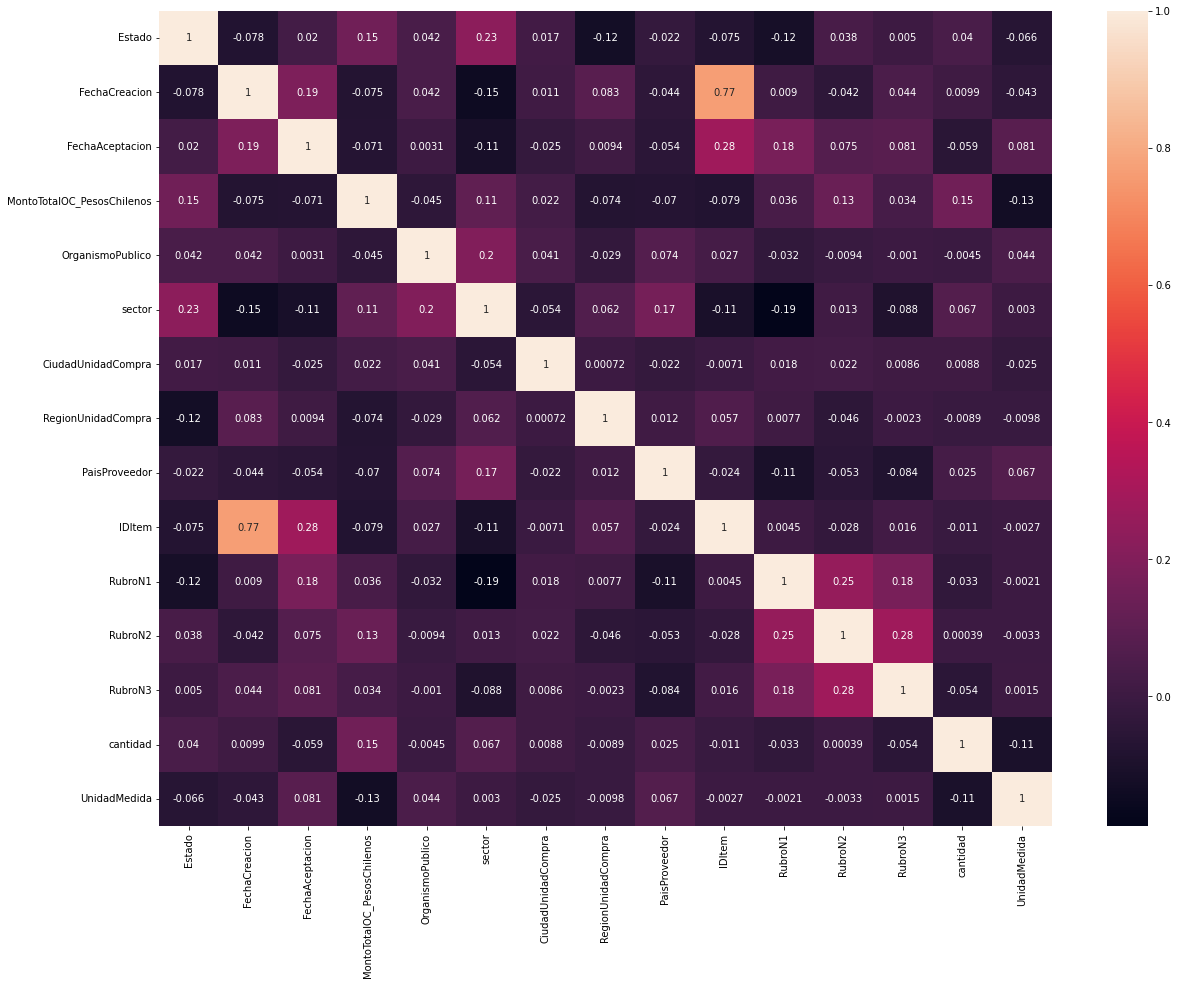

In [56]:
corr = dfpandas.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr,  annot = True)

In [ ]:
# ! pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

In [57]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
%matplotlib inline

profile = ProfileReport(dfpandas, title="Compras del estado Chileno", minimal = True)

In [58]:
profile.to_file("ComprasChile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Análisis de DataSets en base a preguntas objetivo

In [59]:
from pyspark.sql.functions import *

In [60]:
df = df_estados_validos

In [61]:
df = df \
    .withColumn('MontoTotalOC_PesosChilenos', col('MontoTotalOC_PesosChilenos').cast(DoubleType())) \
    .withColumn('IDItem', col('IDItem').cast(IntegerType())) \
    .withColumn('cantidad', col('cantidad').cast(DoubleType())) 

In [62]:
# ¿Cuál fue el gasto promedio en general?
df.select(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio de Gastos")).show()

+------------------+
|Promedio de Gastos|
+------------------+
| 5168789.135800262|
+------------------+



In [63]:
# ¿Cuántos gastos mayores al millón de dólares fueron efectuados entre el año 2021 y mayo de 2022?
df.select(max(col("MontoTotalOC_PesosChilenos") * col("cantidad")).alias("Maximo de Gastos")).show()


+----------------+
|Maximo de Gastos|
+----------------+
| 1.8309884544E17|
+----------------+



In [64]:
# ¿Qué áreas está el Estado chileno invirtiendo más?
df.groupBy("OrganismoPublico").agg(sum(col("MontoTotalOC_PesosChilenos") * col("cantidad")).alias("Total Gastos")).orderBy(desc("Total Gastos")).show(truncate=False)

+---------------------------------------------------------------------+----------------------+
|OrganismoPublico                                                     |Total Gastos          |
+---------------------------------------------------------------------+----------------------+
|CENTRAL DE ABASTECIMIENTO DEL SISTEMA NACIONAL DE SERVICIO DE SALUD  |3.9682824302669914E17 |
|SUBSECRETARIA DEL MINISTERIO DE EDUCACION PUBLICA                    |1.29121365759084768E17|
|HOSPITAL PUERTO MONTT SERVICIO DE SALUD DEL RELONCAVI                |2.123632382315942E15  |
|SUBSECRETARIA DE SALUD PUBLICA                                       |1.178724324269359E15  |
|SERVICIO DE SALUD ANTOFAGASTA HOSPITAL L                             |4.72834148708121E14   |
|SERVICIO DE SALUD METROPOLITANA NORTE HOSPITAL SAN JOSE              |1.36659406165461E14   |
|MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL DE OO PP DCYF           |1.19082476995596E14   |
|HOSPITAL CLINICO METROPOLITANO EL CARMEN DOCTOR L

In [66]:
# ¿En que regiónes se realizáron los mayores gastos?
df.groupBy("RegionUnidadCompra").agg(sum(col("MontoTotalOC_PesosChilenos") * col("cantidad")).alias("Total Gastos")).orderBy(desc("Total Gastos")).show(truncate=False)

+------------------------------------------------+---------------------+
|RegionUnidadCompra                              |Total Gastos         |
+------------------------------------------------+---------------------+
|Región Metropolitana de Santiago                |5.2813788930837517E17|
|Región de los Lagos                             |2.160428030516902E15 |
|Región de Antofagasta                           |4.72797221040176E14  |
|Región del Biobío                               |2.64614145785231E14  |
|Región de Valparaíso                            |2.12729893629553E14  |
|Región del Ñuble                                |1.71484163604997E14  |
|Región del Maule                                |7.1020841975779E13   |
|Región de la Araucanía                          |5.5029937226496E13   |
|Región del Libertador General Bernardo O´Higgins|2.8104457976251E13   |
|Región de Coquimbo                              |2.1739496238133E13   |
|Región de Magallanes y de la Antártica          |1

In [67]:
# ¿En que ciudades se realizáron los mayores gastos?
df.groupBy("CiudadUnidadCompra").agg(sum(col("MontoTotalOC_PesosChilenos") * col("cantidad")).alias("Total Gastos")).orderBy(desc("Total Gastos")).show(truncate=False)

+------------------+----------------------+
|CiudadUnidadCompra|Total Gastos          |
+------------------+----------------------+
|Ñuñoa             |3.9688636760542541E17 |
|Santiago          |1.30356094464647296E17|
|Puerto Montt      |2.138703392981668E15  |
|Antofagasta       |4.71087732172815E14   |
|Chillán           |1.63226287001787E14   |
|Independencia     |1.62900773753371E14   |
|Concepción        |1.46620223208344E14   |
|Valparaíso        |1.30123298330066E14   |
|Maipú             |1.07582553993348E14   |
|Vitacura          |1.03164845703374E14   |
|La Granja         |1.00008765123916E14   |
|Estación Central  |9.124794150408E13     |
|Cerro Navia       |7.4829786793641E13    |
|Hualpén           |6.5112016404355E13    |
|Puente Alto       |6.4586263213885E13    |
|La Florida        |5.5650749633754E13    |
|Viña del Mar      |4.9351819249232E13    |
|Temuco            |3.3547397995923E13    |
|Talca             |3.2936069647872E13    |
|San Miguel        |2.4001453828

In [68]:
# ¿Cuál fue el gasto promedio por mes del estado?
# df.groupBy(month(col("FechaAceptacion"))).agg(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio de Gastos")).orderBy(asc("Promedio de Gastos")).show(truncate=False)
df.groupBy("FechaAceptacion").agg(avg(col("MontoTotalOC_PesosChilenos")).alias("Promedio de Gastos")).orderBy(desc("Promedio de Gastos")).show(truncate=False)

+---------------+--------------------+
|FechaAceptacion|Promedio de Gastos  |
+---------------+--------------------+
|2022-03-16     |3.382011616304348E7 |
|2022-04-08     |1.9053856684210528E7|
|2022-02-20     |1.85665531E7        |
|2022-04-27     |1.181951607142857E7 |
|2022-03-15     |1.050639867857143E7 |
|2022-02-11     |1.0425084027190333E7|
|2022-02-22     |1.0369117344036696E7|
|2022-04-04     |1.0048048944444444E7|
|2022-01-28     |9446558.91342779    |
|2022-01-24     |8590141.620903954   |
|2022-03-01     |8395321.961309524   |
|2022-04-07     |7912777.066666666   |
|2022-01-10     |7760915.800616333   |
|2022-01-16     |7447382.94520548    |
|2022-02-12     |7434552.44          |
|2022-01-26     |7325692.44804944    |
|2022-03-13     |7319320.166666667   |
|2022-01-03     |7111990.664393939   |
|2022-02-24     |7059347.784090909   |
|2022-04-11     |6761864.083333333   |
+---------------+--------------------+
only showing top 20 rows



In [69]:
# ¿Cuál es el tiempo promedio desde que se solicita la orden de compra, hasta que se autorice?
df.select(avg(datediff(col("FechaAceptacion"), col("FechaCreacion"))).alias("Promedio de Tiempo")).orderBy(desc("Promedio de Tiempo")).show(truncate=False)


+------------------+
|Promedio de Tiempo|
+------------------+
|9.250442712944926 |
+------------------+

